#### Observations
- single plant ve multi plantte aynı model kurunca number of parameters değişmiyor, yani multi plantte her planti aynı weightlerle çarpıyor, bunun sonucu olarak da single plantte gelen wmapeler multi de gelemiyor, dense case'i için, CNN performansı fena değil
- convolution hem 1 plantte hem multiple plantte çalışabiliyor, biz 5 kernel size tanımlarken nasıl tek plantte çalışabiliyor bunu iyi anla

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import subprocess; FOLDER_PATH = subprocess.Popen(['git', 'rev-parse', '--show-toplevel'], stdout=subprocess.PIPE).communicate()[0].rstrip().decode('utf-8')
import warnings; warnings.filterwarnings("ignore")
import sys, os; sys.path.append(os.path.dirname(f'{FOLDER_PATH}/utils')); sys.path.append(os.path.dirname(f'{FOLDER_PATH}/scripts'))

In [3]:
import tensorflow as tf
from tensorflow.keras import models, layers
from utils.base_helpers import read_data, split_data, scale_data, plot_metrics
from utils.tf_helpers import WindowGenerator, compile_and_fit, calculate_plantwise_wmape, plot_plantwise_predictions
from scripts.tf_models import BaseTFModel

2022-04-19 23:02:08.776306: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-04-19 23:02:08.776324: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-04-19 23:02:14.690073: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-04-19 23:02:14.690095: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (algopoly): /proc/driver/nvidia/version does not exist


In [4]:
df = read_data(generate_speed_angle=True, add_lagged=True, number_of_plants=1)
train_df, valid_df, test_df = split_data(df, train_ratio=0.8, valid_ratio=0.1)
train_df, valid_df, test_df = scale_data(train_df, valid_df, test_df, scaler="minmax", expand=True)

Selected plants:
 [969]
Train start and end dates:	 2019-01-26 03:00:00 	 2021-06-22 09:00:00
Validation start and end dates:	 2021-06-22 10:00:00 	 2021-10-10 04:00:00
Test start and end dates:	 2021-10-10 05:00:00 	 2022-01-27 23:00:00


In [5]:
OUT_STEPS = 24
INPUT_WIDTH = 30

window = WindowGenerator(
    train_df=train_df, valid_df=valid_df, test_df=test_df, 
    columns=[col for col in df.columns if col != "rt_plant_id"],
    input_width=INPUT_WIDTH, label_width=OUT_STEPS, shift=0, label_columns=["production"])
window

Total window size: 30
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
Label indices: [ 6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29]
Label column name(s): ['production']

In [6]:
val_performance = {}
performance = {}

# Dense

## Linear2

In [32]:
class Linear2(BaseTFModel):
    def __init__(self, window):
        super().__init__(window)

    def add_model(self, model):
        model.add(layers.Dense(self.OUT_STEPS, kernel_initializer=tf.initializers.zeros()))
        model.add(layers.Dropout(0.2))
        return model
    
model = Linear2(window).model
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 start------ (Permute)       (None, 30, 1, 17)         0         
                                                                 
 dense_6 (Dense)             (None, 30, 1, 24)         432       
                                                                 
 dropout_2 (Dropout)         (None, 30, 1, 24)         0         
                                                                 
 end-------- (Reshape)       (None, 1, 720)            0         
                                                                 
 dense_7 (Dense)             (None, 1, 24)             17304     
                                                                 
 permute_13 (Permute)        (None, 24, 1)             0         
                                                                 
 reshape_5 (Reshape)         (None, 24, 1, 1)         

In [33]:
class Linear3(BaseTFModel):
    def __init__(self, window):
        super().__init__(window)

    def add_model(self, model):
        model.add(layers.Permute((2,1,3)))
        model.add(layers.Dense(16, kernel_initializer=tf.initializers.zeros()))
        model.add(layers.Dropout(0.2))
        return model
    
model = Linear3(window).model
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 start------ (Permute)       (None, 30, 1, 17)         0         
                                                                 
 permute_14 (Permute)        (None, 1, 30, 17)         0         
                                                                 
 dense_8 (Dense)             (None, 1, 30, 16)         288       
                                                                 
 dropout_3 (Dropout)         (None, 1, 30, 16)         0         
                                                                 
 end-------- (Reshape)       (None, 1, 480)            0         
                                                                 
 dense_9 (Dense)             (None, 1, 24)             11544     
                                                                 
 permute_15 (Permute)        (None, 24, 1)            

In [35]:
val_performance = {}
performance = {}

param_list = [
    {"loss": "mse", "optimizer": "rmsprop"},
    {"loss": "mse", "optimizer": "adam"},
]

for param_dict in param_list:
    model, history = compile_and_fit(model, window, max_epochs=10, verbose=2, **param_dict)
    val_performance["-".join(param_dict.values())] = model.evaluate(window.valid)
    performance["-".join(param_dict.values())] = model.evaluate(window.test)


Epoch 1/10

Epoch 1: val_wmape improved from inf to 0.25349, saving model to /home/mert/Desktop/thesis/artifacts/checkpoint
329/329 - 2s - loss: 0.0246 - wmape: 0.3715 - val_loss: 0.0189 - val_wmape: 0.2535 - 2s/epoch - 5ms/step
Epoch 2/10

Epoch 2: val_wmape did not improve from 0.25349
329/329 - 0s - loss: 0.0242 - wmape: 0.3691 - val_loss: 0.0204 - val_wmape: 0.2594 - 450ms/epoch - 1ms/step
Epoch 3/10

Epoch 3: val_wmape improved from 0.25349 to 0.24417, saving model to /home/mert/Desktop/thesis/artifacts/checkpoint
329/329 - 0s - loss: 0.0241 - wmape: 0.3674 - val_loss: 0.0176 - val_wmape: 0.2442 - 454ms/epoch - 1ms/step
Epoch 4/10

Epoch 4: val_wmape did not improve from 0.24417
329/329 - 0s - loss: 0.0239 - wmape: 0.3657 - val_loss: 0.0186 - val_wmape: 0.2487 - 419ms/epoch - 1ms/step
Epoch 5/10

Epoch 5: val_wmape did not improve from 0.24417
329/329 - 0s - loss: 0.0239 - wmape: 0.3655 - val_loss: 0.0177 - val_wmape: 0.2455 - 447ms/epoch - 1ms/step
Epoch 6/10

Epoch 6: val_wmape 

# CNN

## Conv4

In [36]:
CONV_WIDTH = 5

class Conv4(BaseTFModel):
    def __init__(self, window):
        super().__init__(window)

    def add_model(self, model):
        model.add(layers.Permute((2,1,3)))
        model.add(layers.Conv2D(64, CONV_WIDTH, activation="relu", padding="same"))
        model.add(layers.Permute((2,3,1)))
        model.add(layers.MaxPooling2D(2))
        model.add(layers.Permute((3,1,2)))
        model.add(layers.Conv2D(32, CONV_WIDTH, activation="relu", padding="same"))
        model.add(layers.Permute((2,3,1)))
        model.add(layers.MaxPooling2D(2))
        model.add(layers.Permute((3,1,2)))
        return model
    
model = Conv4(window).model
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 start------ (Permute)       (None, 30, 1, 17)         0         
                                                                 
 permute_16 (Permute)        (None, 1, 30, 17)         0         
                                                                 
 conv2d_2 (Conv2D)           (None, 1, 30, 64)         27264     
                                                                 
 permute_17 (Permute)        (None, 30, 64, 1)         0         
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 15, 32, 1)        0         
 2D)                                                             
                                                                 
 permute_18 (Permute)        (None, 1, 15, 32)         0         
                                                      

In [37]:
model, history = compile_and_fit(model, window, max_epochs=10, verbose=1, loss="mse", optimizer="adam")
val_performance["CNN"] = model.evaluate(window.valid)
performance["CNN"] = model.evaluate(window.test)

Epoch 1/10
329/329 [==============================] - ETA: 0s - loss: 0.0351 - wmape: 0.4302
Epoch 1: val_wmape improved from inf to 0.24407, saving model to /home/mert/Desktop/thesis/artifacts/checkpoint
329/329 [==============================] - 4s 11ms/step - loss: 0.0351 - wmape: 0.4302 - val_loss: 0.0182 - val_wmape: 0.2441
Epoch 2/10
320/329 [============================>.] - ETA: 0s - loss: 0.0213 - wmape: 0.3340
Epoch 2: val_wmape improved from 0.24407 to 0.23693, saving model to /home/mert/Desktop/thesis/artifacts/checkpoint
329/329 [==============================] - 2s 5ms/step - loss: 0.0212 - wmape: 0.3335 - val_loss: 0.0173 - val_wmape: 0.2369
Epoch 3/10
320/329 [============================>.] - ETA: 0s - loss: 0.0193 - wmape: 0.3166
Epoch 3: val_wmape did not improve from 0.23693
329/329 [==============================] - 2s 5ms/step - loss: 0.0192 - wmape: 0.3158 - val_loss: 0.0182 - val_wmape: 0.2421
Epoch 4/10
320/329 [============================>.] - ETA: 0s - loss:

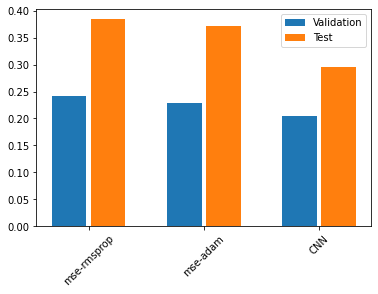

In [38]:
plot_metrics(performance, val_performance)

In [39]:
wmape_df = calculate_plantwise_wmape(model, window, selected_plants=df.rt_plant_id.unique())
wmape_df

,rt_plant_id,wmape,wmape_val
0,969,0.288796,0.202254


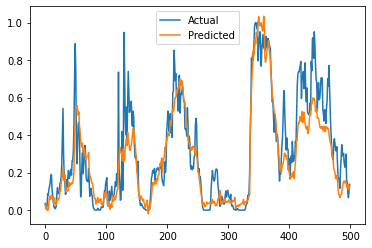

In [40]:
plot_plantwise_predictions(model, window.test)

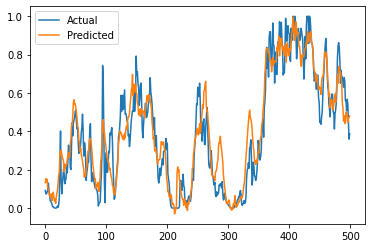

In [41]:
plot_plantwise_predictions(model, window.valid)

# Recurrent

## RNN3

In [7]:
class RNN3(BaseTFModel):
    def __init__(self, window):
        super().__init__(window)

    def add_model(self, model):
        model.add(layers.Permute((2,1,3)))
        model.add(layers.Reshape((self.window.number_of_plants, -1)))
        model.add(layers.Permute((2,1)))
        model.add(layers.MaxPooling1D(2))
        model.add(layers.Permute((2,1)))
        model.add(layers.LSTM(32, return_sequences=True))
        model.add(layers.LSTM(24, return_sequences=True))
        return model
    
model = RNN3(window).model
model.summary()

2022-04-19 23:02:24.303037: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 start------ (Permute)       (None, 30, 1, 17)         0         
                                                                 
 permute (Permute)           (None, 1, 30, 17)         0         
                                                                 
 reshape (Reshape)           (None, 1, 510)            0         
                                                                 
 permute_1 (Permute)         (None, 510, 1)            0         
                                                                 
 max_pooling1d (MaxPooling1D  (None, 255, 1)           0         
 )                                                               
                                                                 
 permute_2 (Permute)         (None, 1, 255)            0         
                                                        

In [ ]:
history = compile_and_fit(model, window, max_epochs=10, verbose=1, loss="mse", optimizer="adam")

Epoch 1/10


2022-04-19 23:02:41.463639: I tensorflow/compiler/xla/service/service.cc:171] XLA service 0x7fc04c04cbf0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2022-04-19 23:02:41.463684: I tensorflow/compiler/xla/service/service.cc:179]   StreamExecutor device (0): Host, Default Version
2022-04-19 23:02:41.526434: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:237] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2022-04-19 23:02:42.411060: I tensorflow/compiler/jit/xla_compilation_cache.cc:399] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


 64/329 [====>.........................] - ETA: 4:23 - loss: 0.1142 - wmape: 0.8542

In [ ]:
val_performance['RNN3'] = model.evaluate(window.valid)
performance['RNN3'] = model.evaluate(window.test)
